In [473]:
import numpy
import sklearn
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from scipy.optimize import minimize
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch
from itertools import product
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torchvision
from torchvision.transforms import transforms
from sklearn.decomposition import PCA, FastICA
from ERM import sklearn_optimize, error, adversarial_error
from helpers import ProblemType
from data_model import KFeaturesModel
import pickle
from collections import namedtuple
import os
from pathlib import Path
from functools import wraps

import logging
logger = logging.getLogger()


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [418]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [419]:
plt.style.use("latex_ready.mplstyle")

In [420]:
def cifar10_plot(ax, im, label):
    
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    ax.imshow(img,  interpolation='nearest') 
    if hasattr(ax,"set_title"):
        ax.set_title(label)
    elif hasattr(ax,"title"):
        ax.title(label)
    else:
        raise ValueError("Unable to set title")
    ax.axis("off")

In [421]:
def plot_cifar10_subset(data, labels, subset: str):
    # display some random images from both classes including a label for each image
    fig, ax = plt.subplots(2, 5)
    fig.suptitle(f"Random images from the {subset} dataset")
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, data.shape[0])
            

            cifar10_plot(ax[i, j], data[idx], labels[idx])               
                       
            
    plt.show()

In [422]:
FIRST_LABEL = 3
SECOND_LABEL = 1
def preprocess_cifar10_data_labels(data, labels, subset):
    labels = np.array(labels)
    data = np.array(data)
    
    print(subset, labels.shape, data.shape)

    mask = (labels == FIRST_LABEL) | (labels == SECOND_LABEL)
    label_subset = labels[mask]
    data_subset = data[mask]
        
    mask_first = label_subset == FIRST_LABEL
    mask_second = label_subset == SECOND_LABEL
    
    # label the FIRST_LABEL as 1
    # label the SECOND_LABEL as -1
    label_subset[mask_first] = 1
    label_subset[mask_second] = -1

    plot_cifar10_subset(data_subset, label_subset, subset)    

    return data_subset, label_subset


In [423]:
def prepare_cifar10_data():
    # get test data
    cifar_10_test_data = unpickle("./data/cifar-10-batches-py/test_batch")[b"data"]
    cifar_10_test_labels = unpickle("./data/cifar-10-batches-py/test_batch")[b"labels"]

    cifar_10_test_data, cifar_10_test_labels = preprocess_cifar10_data_labels(cifar_10_test_data, cifar_10_test_labels, "test:")

    # merge train data
    cifar_10_data = []
    cifar_10_labels = []
    for i in range(1,6):
        data = unpickle("./data/cifar-10-batches-py/data_batch_"+str(i))
        cifar_10_data.append(data[b'data'])
        cifar_10_labels += data[b'labels']
    cifar_10_data = np.concatenate(cifar_10_data)

    cifar_10_data, cifar_10_labels = preprocess_cifar10_data_labels(cifar_10_data, cifar_10_labels, "train:")

    X = StandardScaler().fit(cifar_10_data).transform(cifar_10_data)
    X_test = StandardScaler().fit(cifar_10_test_data).transform(cifar_10_test_data)
    # X = cifar_10_data
    # X_test = cifar_10_test_data

    return X, X_test, cifar_10_labels, cifar_10_test_labels

test: (10000,) (10000, 3072)


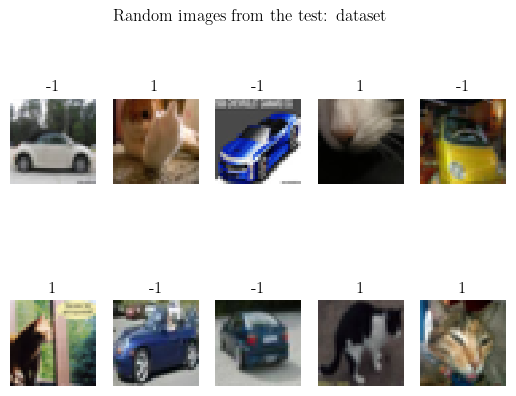

train: (50000,) (50000, 3072)


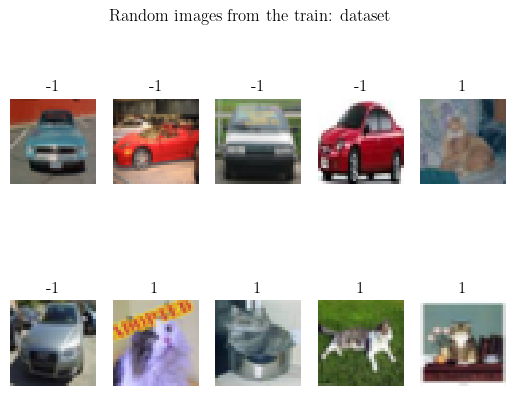

In [424]:
X, X_test, y, y_test = prepare_cifar10_data()

# FastICA

In [425]:
def ica_fit_transform(X, X_test, n_components, whiten="unit-variance"):
    ica = FastICA(n_components=n_components, whiten=whiten, max_iter=1000)
    ica.fit(X)
    X_train_transformed = ica.transform(X)
    X_test_transformed = ica.transform(X_test)
    return X_train_transformed, X_test_transformed

def pca_fit_transform(X, X_test, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_train_transformed = pca.transform(X)
    X_test_transformed = pca.transform(X_test)
    return X_train_transformed, X_test_transformed


In [426]:

def evaluate(w, X_train, X_test, y_train, y_test, attack_epsilon, sigma_upsilon):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.5f}")
    print(f"Test error: {error(y_pred_test, y_test):.5f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.5f}")

def optimize_adversarial_problem(X_train, y_train, X_test, y_test, lam, epsilon, attack_epsilon, sigma_upsilon = None,sigma_delta = None):
    problem_type = ProblemType.Logistic
    d = X_train.shape[1]
    w = np.ones(d)/d**2

    if sigma_delta is None:
        sigma_delta = np.diag(np.ones(d))

    if sigma_upsilon is None:
        sigma_upsilon = np.diag(np.ones(d))

    weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

    # lg = LogisticRegression()
    # lg.fit(X_train, y_train)

    # weights = lg.weights

    evaluate(weights, X_train, X_test, y_train, y_test, attack_epsilon, sigma_upsilon)

    return weights

In [449]:
def read_experiment_from_pickle(filename):
    with open(filename, "rb") as f:
        experiment = pickle.load(f)
        return experiment
        

def write_experiment_to_pickle(experiment, filename):
    with open(filename, 'wb') as file:
            pickle.dump(experiment, file)


In [470]:

def serialize_output_to_file(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
    
        key_set = {"dataset_name", "lam", "epsilon", "attack_epsilon", "n_components", "dimensionality_reduction_type"}

        # Create a filename from kwargs by joining key-value pairs
        filename = '_'.join(f"{key}_{value}" for key, value in kwargs.items() if key in key_set)
        filename = f"{filename}.pkl" if filename else "default_output.pkl"
        
        # Ensure the filename is valid by replacing any problematic characters
        filename = filename.replace('/', '_').replace('\\', '_').replace(':', '_')

        # Create a Paths object
        path = Path("EmpiricalExperiments")

        # Ensure path exists
        path.mkdir(parents=True, exist_ok=True)

        path /= filename

        # raise an exception if file exists
        if path.exists():
            print("File for this experiment already exists. Hence loading existing experiment")
            return read_experiment_from_pickle(path)
        
        # Call the original function and get the result
        experiment = func(*args, **kwargs)       


        # Serialize the result to the generated filename
        write_experiment_to_pickle(experiment, path)
        
        print(f"Output saved to {path}")
        return experiment
    
    return wrapper
    

Experiment = namedtuple('Experiment', 'X_tr X_tr_test y y_test w dataset_name lam epsilon attack_epsilon n_components dimensionality_reduction_type')

@serialize_output_to_file
def get_experiment_instance(dataset_name, lam, epsilon, attack_epsilon, n_components, dimensionality_reduction_type, X, X_test, y, y_test):
    """
    Computes experiment and serializes result it or loads serialized result.

    Usage example:
    experiment = get_experiment_instance(
        dataset_name="cifar10",
        lam=lam,
        epsilon=epsilon,
        attack_epsilon=attack_epsilon,
        n_components=n_components,
        X=X,
        X_test=X_test, 
        y=y, 
        y_test=y_test,
        dimensionality_reduction_type=dimensionality_reduction_type,
    )
    
    """
    match dimensionality_reduction_type:
        case "ICA":
            X_tr, X_tr_test = ica_fit_transform(X, X_test, n_components=n_components)
        case "PCA":
            X_tr, X_tr_test = pca_fit_transform(X, X_test, n_components=n_components)
        case "COMPONENT":
            # Take the first n components
            X_tr, X_tr_test = X[:,:n_components], X_test[:,:n_components]
        case _:
            raise ValueError("Unknonw dimensionality reduction")
        
    
    sigma_upsilon = np.diag(np.ones(n_components))
    sigma_delta = np.diag(np.ones(n_components))
    w = optimize_adversarial_problem(X_tr, y, X_tr_test, y_test, lam=lam, epsilon = epsilon, attack_epsilon = attack_epsilon, sigma_upsilon=sigma_upsilon, sigma_delta=sigma_delta)

    experiment = Experiment(**{
        "X_tr": X_tr,
        "X_tr_test": X_tr_test,
        "y": y,
        "y_test": y_test,
        "w": w,
        "dataset_name": dataset_name,
        "lam": lam,
        "epsilon": epsilon,
        "attack_epsilon": attack_epsilon,
        "n_components": n_components,
        "dimensionality_reduction_type": dimensionality_reduction_type,
    })

    return experiment



In [477]:


lam = 0.01
epsilon = 0
attack_epsilon = 1
n_components = 20
dimensionality_reduction_type = "ICA"

# Define possible types for each keyword argument
arguments = {
    'lam': np.array([0.01]),
    'epsilon': np.array([0]), 
    'attack_epsilon': np.array([0]),
    'n_components': np.linspace(5,X.shape[1],10, dtype=int),       
    'dimensionality_reduction_type': ["ICA"]       
}

# NOTE
# n_components for which ICA did not converge
# For cifar10:
# 5
# It did converge for 345
# TODO this is a bit of a mess. Why? Because the 3 different color channels add correlations. Let's convert the images to greyscale!
# TODO might still be worth capturing outputs in experiment information to keep us notified of any problems...


# Extract argument names and their type lists
arg_names = list(arguments.keys())
type_combinations = list(product(*arguments.values()))

# Total number of type combinations
total_combinations = len(type_combinations)

my_experiments = []

# Iterate over all type combinations and track progress
for combination in tqdm(type_combinations, total=total_combinations, desc="Processing type combinations"):
    # Create a dict with argument names and their corresponding type in this combination
    kwargs_combination = dict(zip(arg_names, combination))
    print(kwargs_combination)  # Replace this with the processing logic you need
    experiment = get_experiment_instance(
        dataset_name="cifar10",
        **kwargs_combination,
        X=X,
        X_test=X_test, 
        y=y, 
        y_test=y_test,        
    )
    my_experiments.append(experiment)


Processing type combinations:   0%|          | 0/10 [00:00<?, ?it/s]

{'lam': 0.01, 'epsilon': 0, 'attack_epsilon': 0, 'n_components': 5, 'dimensionality_reduction_type': 'ICA'}


/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Processing type combinations:  10%|█         | 1/10 [00:40<06:03, 40.39s/it]

Training error: 0.25940
Test error: 0.25950
Adversarial error: 0.25950
Output saved to EmpiricalExperiments/dataset_name_cifar10_lam_0.01_epsilon_0_attack_epsilon_0_n_components_5_dimensionality_reduction_type_ICA.pkl
{'lam': 0.01, 'epsilon': 0, 'attack_epsilon': 0, 'n_components': 345, 'dimensionality_reduction_type': 'ICA'}


Processing type combinations:  20%|██        | 2/10 [01:48<07:32, 56.61s/it]

Training error: 0.16220
Test error: 0.18450
Adversarial error: 0.18450
Output saved to EmpiricalExperiments/dataset_name_cifar10_lam_0.01_epsilon_0_attack_epsilon_0_n_components_345_dimensionality_reduction_type_ICA.pkl
{'lam': 0.01, 'epsilon': 0, 'attack_epsilon': 0, 'n_components': 686, 'dimensionality_reduction_type': 'ICA'}


/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Processing type combinations:  30%|███       | 3/10 [08:47<25:53, 221.95s/it]

Training error: 0.15400
Test error: 0.19550
Adversarial error: 0.19550
Output saved to EmpiricalExperiments/dataset_name_cifar10_lam_0.01_epsilon_0_attack_epsilon_0_n_components_686_dimensionality_reduction_type_ICA.pkl
{'lam': 0.01, 'epsilon': 0, 'attack_epsilon': 0, 'n_components': 1027, 'dimensionality_reduction_type': 'ICA'}


/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Processing type combinations:  40%|████      | 4/10 [22:16<45:24, 454.07s/it]

Training error: 0.14200
Test error: 0.20050
Adversarial error: 0.20050
Output saved to EmpiricalExperiments/dataset_name_cifar10_lam_0.01_epsilon_0_attack_epsilon_0_n_components_1027_dimensionality_reduction_type_ICA.pkl
{'lam': 0.01, 'epsilon': 0, 'attack_epsilon': 0, 'n_components': 1368, 'dimensionality_reduction_type': 'ICA'}


Processing type combinations:  40%|████      | 4/10 [27:03<40:35, 405.89s/it]


KeyboardInterrupt: 

In [ ]:
experiment = get_experiment_instance(
    dataset_name="cifar10",
    lam=0.01,
    epsilon=0,
    attack_epsilon=1,
    n_components=10,
    X=X,
    X_test=X_test, 
    y=y, 
    y_test=y_test,
    dimensionality_reduction_type=dimensionality_reduction_type,
)

In [410]:
def plot_metrics(metrics, ylabel):
    tuple_size = (8.5,2.4)


    fig, ax = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=( tuple_size[0], tuple_size[1]),
        gridspec_kw={"hspace": 0,"wspace": 0.5},
    )


    # ICML adjustments
    fig.subplots_adjust(left=0.08)
    fig.subplots_adjust(bottom=0.12)
    fig.subplots_adjust(top=0.99)
    fig.subplots_adjust(right=0.97)

    print("Figure size in inches: ", fig.get_size_inches())

    # fig.suptitle(f"Evaluate {ylabel}")  

    # plot the norm of each component of the weight vector
    ax[0].plot(metrics, marker="o", linewidth=0, markersize=1)
    ax[0].set_xlabel("Independent Component")
    ax[0].set_ylabel(ylabel)
    ax[0].set_yscale("log")

    ax[1].hist(metrics)
    ax[1].set_xlabel(ylabel)
    ax[1].set_ylabel(f"{ylabel} Count")
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    
    ax[0].grid(which="both", axis="both", alpha=0.5)
    ax[1].grid(which="both", axis="both", alpha=0.5)
    # Set the major ticks to face inwards
    ax[0].tick_params(axis='both', which='major', direction='in')
    ax[1].tick_params(axis='both', which='major', direction='in')
    # Set the minor ticks to face inwards
    ax[0].tick_params(axis='both', which='minor', direction='in')
    ax[1].tick_params(axis='both', which='minor', direction='in')

    plt.show()

Figure size in inches:  [8.5 2.4]


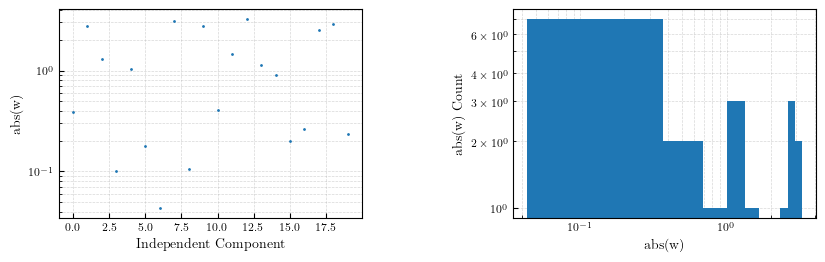

In [411]:
# plot the norm of each component of the weight vector
plot_metrics(np.abs(w), ylabel="abs(w)")

Figure size in inches:  [8.5 2.4]


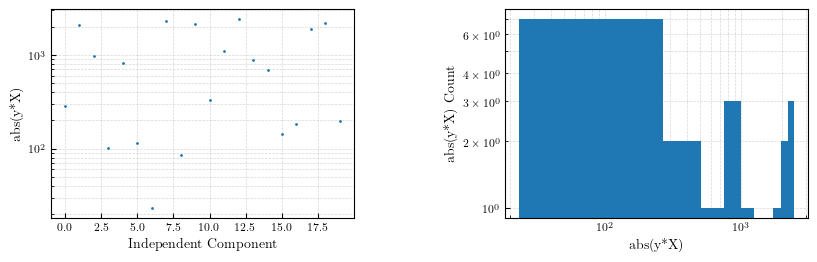

In [412]:
# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X_tr, axis=0)
plot_metrics(abs(yX), ylabel="abs(y*X)")

Figure size in inches:  [8.5 2.4]


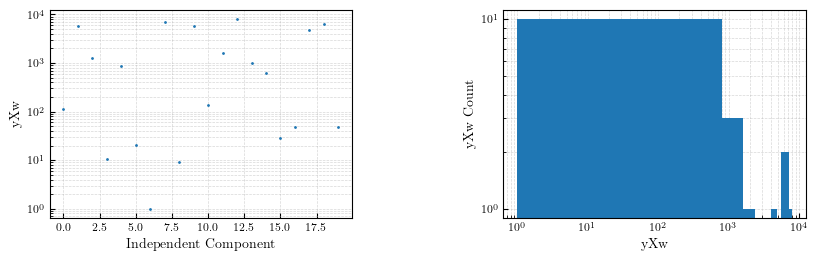

In [415]:

# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X_tr, axis=0)
# compute elementwise yX * weights
yXw = yX * w
plot_metrics(yXw, ylabel="yXw")


Figure size in inches:  [8.5 2.4]


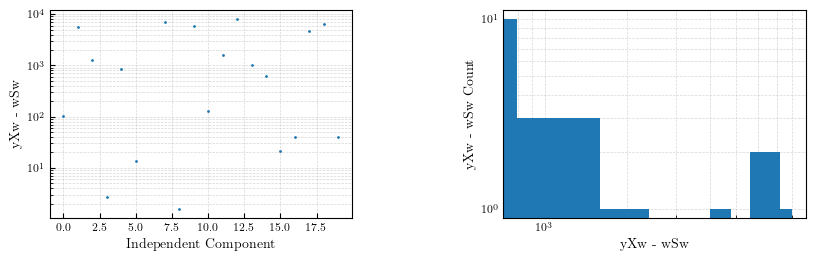

In [416]:
wSw = w.dot(sigma_upsilon).dot(w)
optimal_attack = attack_epsilon * np.sqrt(wSw)
# plot yXw - optimal_attack
attacked = yXw-optimal_attack
plot_metrics(attacked, ylabel="yXw - wSw")
